# Test validity step 1 : $P(\eta | ...) \propto \eta^t \left( C_{approx}^{1/2} (C_{approx}^{-1} + (E^t (B^t N^{-1} B)^{-1} E)^{-1}) C_{approx}^{1/2} \right)^{-1} \eta$

In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import astropy.io.fits as fits
import scipy
import camb
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import jax_healpy as jhp
import jax.lax as jlx

import micmac as micmac

In [2]:
sys.path.append(os.path.dirname(os.path.abspath('')))
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('')))+'/tutorials/')
# from func_tools_for_tests import *
from get_freq_maps_SO_64 import *
# from get_freq_maps_SO_64_lower_noise import *
# from get_freq_maps_LiteBIRD_64 import *
# freq_maps is defined there

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Shape for input frequency maps : (6, 2, 49152)
Shape for input cmb maps : (6, 2, 49152)


In [3]:
instrument

,frequency,depth_p,depth_i,fwhm,f_sky,status,reference,type,note,experiment
0,27.0,49.5,35.0,91.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
1,39.0,29.7,21.0,63.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
2,93.0,3.7,2.6,30.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
3,145.0,4.7,3.3,17.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
4,225.0,8.9,6.3,11.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
5,280.0,22.6,16.0,9.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT


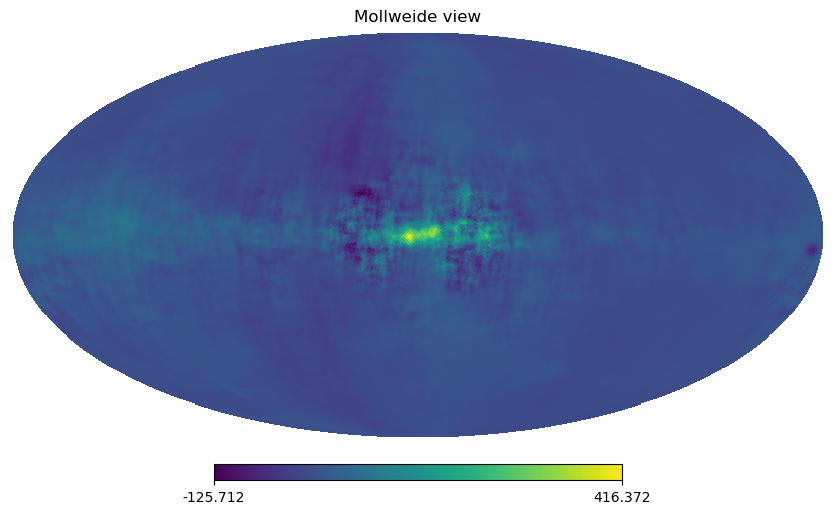

In [4]:
hp.mollview(freq_maps[0,0]) # Freq, nstokes, npix

In [5]:

working_directory_path = '/Users/mag/Documents/PHD1Y/Space_Work/Pixel_non_P2D/MICMAC/test_playground/validation_chain_v5/'
directory_save_file = working_directory_path + 'save_directory/'
directory_toml_file = working_directory_path + 'toml_params/'

path_toml_file = directory_toml_file + 'biased_full_chain_v1a.toml'

MICMAC_sampler_obj = micmac.create_MICMAC_sampler_from_toml_file(path_toml_file)


In [6]:
path_mask = "/Users/mag/Documents/PHD1Y/Masks/mask_SAT_apodized.fits"

apod_mask = hp.ud_grade(hp.read_map(path_mask),nside_out=MICMAC_sampler_obj.nside)
mask = np.copy(apod_mask)
mask[apod_mask>0] = 1

mask = np.ones(MICMAC_sampler_obj.npix)

MICMAC_sampler_obj.mask = mask

In [7]:
%%time

freq_inverse_noise = MICMAC_sampler_obj.freq_inverse_noise

freq_inverse_noise_masked = np.zeros((MICMAC_sampler_obj.number_frequencies,MICMAC_sampler_obj.number_frequencies,MICMAC_sampler_obj.npix))

nb_pixels_mask = int(mask.sum())
freq_inverse_noise_masked[:,:,mask!=0] = np.repeat(freq_inverse_noise.ravel(order='F'), nb_pixels_mask).reshape((MICMAC_sampler_obj.number_frequencies,MICMAC_sampler_obj.number_frequencies,nb_pixels_mask), order='C')


CPU times: user 42.4 ms, sys: 3 ms, total: 45.4 ms
Wall time: 44.1 ms


In [8]:
MICMAC_sampler_obj.freq_inverse_noise = freq_inverse_noise_masked

In [9]:
MICMAC_sampler_obj.freq_inverse_noise[:,:,mask==0]

array([], shape=(6, 6, 0), dtype=float64)

In [10]:
input_freq_maps, _, theoretical_red_cov_r0_total, theoretical_red_cov_r1_tensor = MICMAC_sampler_obj.generate_input_freq_maps_from_fgs(freq_maps_fgs, return_only_freq_maps=False)

# Re-Defining the data if needed
indices_polar = np.array([1,2,4])
partial_indices_polar = indices_polar[:MICMAC_sampler_obj.nstokes]


theoretical_r0_total = micmac.get_c_ells_from_red_covariance_matrix(theoretical_red_cov_r0_total)#[partial_indices_polar,:]
theoretical_r1_tensor = micmac.get_c_ells_from_red_covariance_matrix(theoretical_red_cov_r1_tensor)#[partial_indices_polar,:]


c_ell_approx = np.zeros((3,MICMAC_sampler_obj.lmax+1))
c_ell_approx[0,MICMAC_sampler_obj.lmin:] = theoretical_r0_total[0,:]
c_ell_approx[1,MICMAC_sampler_obj.lmin:] = theoretical_r0_total[1,:]

# Params mixing matrix
init_mixing_matrix_obj = micmac.InitMixingMatrix(MICMAC_sampler_obj.frequency_array, MICMAC_sampler_obj.number_components, pos_special_freqs=MICMAC_sampler_obj.pos_special_freqs)
exact_params_mixing_matrix = init_mixing_matrix_obj.init_params()

mixing_matrix_obj = micmac.MixingMatrix(MICMAC_sampler_obj.frequency_array, MICMAC_sampler_obj.number_components, exact_params_mixing_matrix, pos_special_freqs=MICMAC_sampler_obj.pos_special_freqs)

mixing_matrix_sampled = mixing_matrix_obj.get_B()

BtinvNB = micmac.get_inv_BtinvNB(MICMAC_sampler_obj.freq_inverse_noise, mixing_matrix_sampled)
BtinvN_sqrt = micmac.get_BtinvN(np.sqrt(MICMAC_sampler_obj.freq_inverse_noise), mixing_matrix_sampled)

Calculating spectra from CAMB !
Calculating spectra from CAMB !


In [11]:
red_cov_approx_matrix = micmac.get_reduced_matrix_from_c_ell(c_ell_approx)[MICMAC_sampler_obj.lmin:,...]

In [12]:
red_cov_approx_matrix.shape

(127, 2, 2)

In [13]:
lmax = MICMAC_sampler_obj.lmax
n_iter = MICMAC_sampler_obj.n_iter
lmin = MICMAC_sampler_obj.lmin
nstokes = MICMAC_sampler_obj.nstokes
nside = MICMAC_sampler_obj.nside
number_frequencies = MICMAC_sampler_obj.number_frequencies
npix = MICMAC_sampler_obj.npix


In [14]:
jax_key_PNRG = jax.random.PRNGKey(MICMAC_sampler_obj.seed+10)
jax_key_PNRG = jax.random.PRNGKey(MICMAC_sampler_obj.seed+20)


In [15]:
%%time

map_random_x = jnp.empty(0)
map_random_y = jnp.empty(0)
eta_maps = MICMAC_sampler_obj.get_sampling_eta_v2(red_cov_approx_matrix, BtinvNB, BtinvN_sqrt, jax_key_PNRG, map_random_x=map_random_x, map_random_y=map_random_y, suppress_low_modes=True)


Recalculating x !
Recalculating y !
CPU times: user 5.66 s, sys: 1.02 s, total: 6.68 s
Wall time: 2.41 s


In [16]:
jitted_sampling_eta = jax.jit(MICMAC_sampler_obj.get_sampling_eta_v2, static_argnames=['suppress_low_modes'])

In [17]:
%%time
eta_maps = jitted_sampling_eta(red_cov_approx_matrix, BtinvNB, BtinvN_sqrt, jax_key_PNRG, map_random_x=map_random_x, map_random_y=map_random_y, suppress_low_modes=True)


Recalculating x !
Recalculating y !
CPU times: user 1.83 s, sys: 246 ms, total: 2.07 s
Wall time: 917 ms


In [18]:
%%time
eta_maps = jitted_sampling_eta(red_cov_approx_matrix, BtinvNB, BtinvN_sqrt, jax_key_PNRG, map_random_x=map_random_x, map_random_y=map_random_y, suppress_low_modes=True)


CPU times: user 466 ms, sys: 60.1 ms, total: 526 ms
Wall time: 80.7 ms


In [19]:
# %%time
# eta_maps = jitted_sampling_eta(red_cov_approx_matrix, BtinvNB, BtinvN_sqrt, jax_key_PNRG, map_random_x=map_random_x, map_random_y=map_random_y, suppress_low_modes=True)


In [20]:
# %%time
# eta_maps = jitted_sampling_eta(red_cov_approx_matrix, BtinvNB, BtinvN_sqrt, jax_key_PNRG, map_random_x=map_random_x, map_random_y=map_random_y, suppress_low_modes=True)


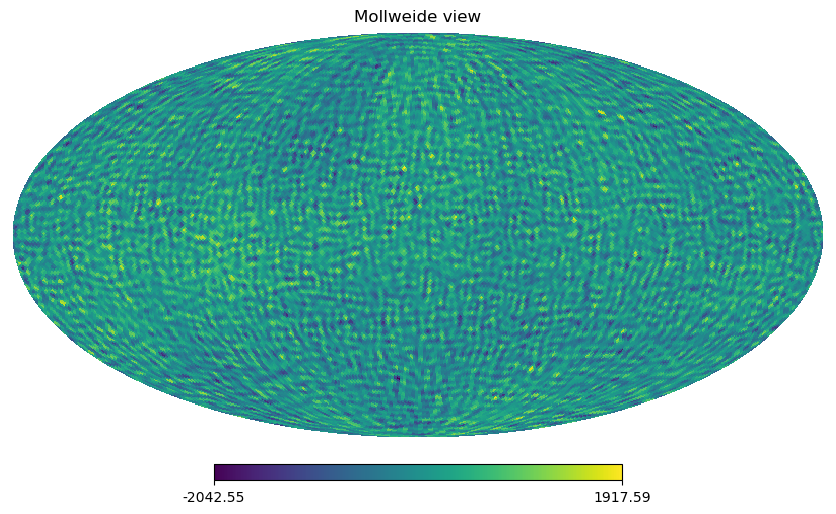

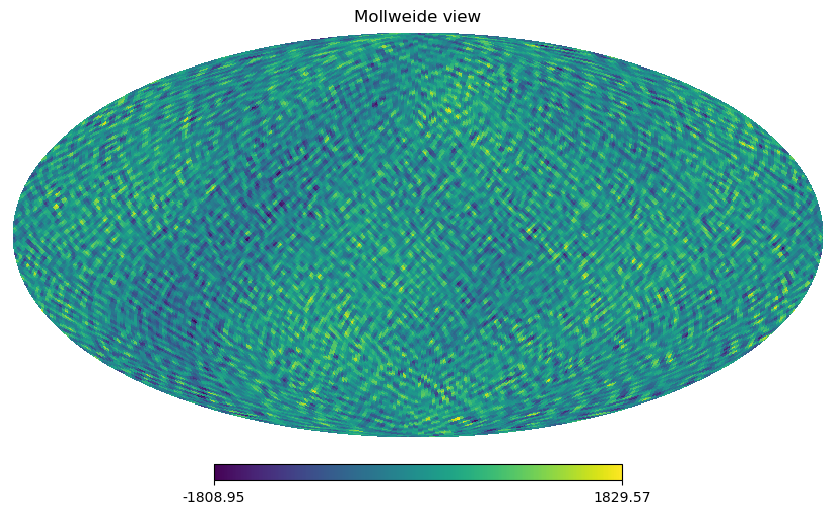

In [21]:
hp.mollview(eta_maps[0])
hp.mollview(eta_maps[1])

In [22]:
%%time

map_random_x = jnp.empty(0)
map_random_y = jnp.empty(0)
eta_maps_v1 = MICMAC_sampler_obj.get_sampling_eta_v1(red_cov_approx_matrix, BtinvNB, BtinvN_sqrt, jax_key_PNRG, map_random_x=map_random_x, map_random_y=map_random_y, suppress_low_modes=True)

Recalculating x !
Recalculating y !
CPU times: user 1.3 s, sys: 304 ms, total: 1.61 s
Wall time: 257 ms


In [23]:
jitted_sampling_eta_v1 = jax.jit(MICMAC_sampler_obj.get_sampling_eta_v1, static_argnames=['suppress_low_modes'])

In [24]:
%%time

map_random_x = jnp.empty(0)
map_random_y = jnp.empty(0)
eta_maps_v1 = jitted_sampling_eta_v1(red_cov_approx_matrix, BtinvNB, BtinvN_sqrt, jax_key_PNRG, map_random_x=map_random_x, map_random_y=map_random_y, suppress_low_modes=True)

Recalculating x !
Recalculating y !
CPU times: user 1.1 s, sys: 158 ms, total: 1.25 s
Wall time: 693 ms


In [25]:
%%time

map_random_x = jnp.empty(0)
map_random_y = jnp.empty(0)
eta_maps_v1 = jitted_sampling_eta_v1(red_cov_approx_matrix, BtinvNB, BtinvN_sqrt, jax_key_PNRG, map_random_x=map_random_x, map_random_y=map_random_y, suppress_low_modes=True)

CPU times: user 229 ms, sys: 40.2 ms, total: 269 ms
Wall time: 48.3 ms


In [26]:
component_eta_map_prime = np.einsum('kcp,cfp,fsp->ksp', BtinvNB, BtinvN_sqrt, eta_maps_v1)[0]#*hp.nside2resol(nside)


In [27]:
jax_key_PNRG = jax.random.PRNGKey(MICMAC_sampler_obj.seed+100)
new_eta_maps_v1 = MICMAC_sampler_obj.get_sampling_eta_v1(red_cov_approx_matrix, BtinvNB, BtinvN_sqrt, jax_key_PNRG+1, map_random_x=map_random_x, map_random_y=map_random_y, suppress_low_modes=True)
old_eta_maps_v1 = np.copy(eta_maps_v1)

Recalculating x !
Recalculating y !


In [28]:
overrelaxation_param = -.89

eta_maps_overrel_v1 = old_eta_maps_v1*overrelaxation_param + ((1-overrelaxation_param**2)**.5)*new_eta_maps_v1

component_eta_map_v1 = np.einsum('kcp,cfp,fsp->ksp', BtinvNB, BtinvN_sqrt, eta_maps_overrel_v1)[0]
eta_maps_overrel_v1_extended = np.vstack([np.zeros_like(component_eta_map_v1[0]), component_eta_map_v1])
c_ells_eta_overrel_v1 = hp.anafast(eta_maps_overrel_v1_extended, lmax=lmax, iter=n_iter)[indices_polar,lmin:]

In [29]:
jax_key_PNRG = jax.random.PRNGKey(MICMAC_sampler_obj.seed+100)
new_eta_maps = MICMAC_sampler_obj.get_sampling_eta_v2(red_cov_approx_matrix, BtinvNB, BtinvN_sqrt, jax_key_PNRG+1, map_random_x=map_random_x, map_random_y=map_random_y, suppress_low_modes=True)
old_eta_maps = np.copy(eta_maps)

Recalculating x !
Recalculating y !


In [30]:
overrelaxation_param = -.89

eta_maps_overrel = old_eta_maps*overrelaxation_param + ((1-overrelaxation_param**2)**.5)*new_eta_maps
eta_maps_overrel_extended = np.vstack([np.zeros_like(eta_maps_overrel[0]), eta_maps_overrel])
c_ells_eta_overrel = hp.anafast(eta_maps_overrel_extended, lmax=lmax, iter=n_iter)[indices_polar,lmin:]

In [31]:
print(np.einsum('sp,sp',old_eta_maps,old_eta_maps)/((nstokes*npix)**2))
print(np.einsum('sp,sp',old_eta_maps,new_eta_maps)/((nstokes*npix)**2))
print(np.einsum('sp,sp',eta_maps_overrel,old_eta_maps)/((nstokes*npix)**2))

2.1598223278104487
-0.01845476817378104
-1.930656517529321


In [32]:
eta_maps_extended = np.vstack([np.zeros_like(eta_maps[0]), eta_maps])
c_ells_eta = hp.anafast(eta_maps_extended, lmax=lmax, iter=n_iter)[indices_polar,lmin:]

In [33]:
eta_maps_v1_extended = np.vstack([np.zeros_like(component_eta_map_prime[0]), component_eta_map_prime])
c_ells_eta_v1 = hp.anafast(eta_maps_v1_extended, lmax=lmax, iter=n_iter)[indices_polar,lmin:]

In [34]:
# covariance_noise = np.zeros_like(c_ell_approx)
# # covariance_noise[:nstokes,lmin:] = scipy.linalg.sqrtm(BtinvNB)[0,0]*np.ones_like(c_ell_approx)[:nstokes,lmin:]
# covariance_noise[:nstokes,lmin:] = BtinvNB[0,0]*np.ones_like(c_ell_approx)[:nstokes,lmin:]

_cl_noise_harm = micmac.get_Cl_noise(np.array(instrument['depth_p']), mixing_matrix_sampled, MICMAC_sampler_obj.lmax)[0,0,lmin:]

red_cl_noise_harm = micmac.get_reduced_matrix_from_c_ell(np.array([_cl_noise_harm,_cl_noise_harm,np.zeros_like(_cl_noise_harm)]))


In [42]:
# analytical_eta_term = (c_ell_approx + covariance_noise)/np.sqrt(BtinvNB[0,0])

red_cov_approx_matrix_msqrt = np.linalg.pinv(micmac.get_sqrt_reduced_matrix_from_matrix(red_cov_approx_matrix))
red_cov_approx_matrix_sqrt = micmac.get_sqrt_reduced_matrix_from_matrix(red_cov_approx_matrix)

red_cl_noise_harm_sqrt = micmac.get_sqrt_reduced_matrix_from_matrix(red_cl_noise_harm)
red_cl_noise_harm_msqrt = np.linalg.pinv(micmac.get_sqrt_reduced_matrix_from_matrix(red_cl_noise_harm))

analytical_eta_term_cov = np.einsum('lij,ljk,lkm->lim', red_cov_approx_matrix_sqrt, np.linalg.pinv(red_cov_approx_matrix) + np.linalg.pinv(red_cl_noise_harm), red_cov_approx_matrix_sqrt)
analytical_eta_term_2 = np.zeros_like(c_ell_approx)
analytical_eta_term_2[:,lmin:] = micmac.get_c_ells_from_red_covariance_matrix(analytical_eta_term_cov)


analytical_eta_term_cov_v1 = np.einsum('lij,ljk,lkm->lim', red_cl_noise_harm_msqrt, red_cov_approx_matrix + red_cl_noise_harm, red_cl_noise_harm_msqrt)
analytical_eta_term_v1 = np.zeros_like(c_ell_approx)
analytical_eta_term_v1[:,lmin:] = micmac.get_c_ells_from_red_covariance_matrix(analytical_eta_term_cov_v1)


In [43]:
number_correl_to_plot = int(np.ceil(nstokes**2/2) + np.floor(nstokes/2))

if nstokes == 3:
    number_subplots_convention = 421
    figsize = (10,10)
    figsize_big = (12,12)
    position_legend = int(number_correl_to_plot/2)-1
    bbox_to_anchor=(2.2, 1)
elif nstokes == 2:
    number_subplots_convention = 131
    figsize = (14,6)
    figsize_big = figsize
    position_legend = number_correl_to_plot-1
    bbox_to_anchor=(1, 1)
else:
    number_subplots_convention = 111
    figsize = (10,10)
    figsize_big = (10,10)
    position_legend = int(number_correl_to_plot/2)-1
    bbox_to_anchor=(2.2, 1)

In [44]:
fksy = mask.sum()/mask.size
fksy = 1

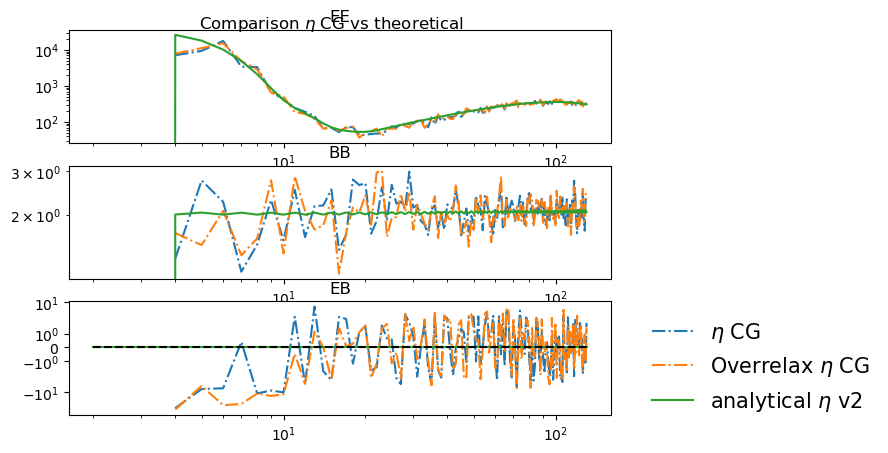

In [45]:
# list_correl = ['TT', 'EE', 'BB', 'TE', 'EB', 'TB']
list_correl = ['EE', 'BB', 'EB']

ell_arange = np.arange(c_ell_approx.shape[1]) + lmin

plt.figure(figsize=(7,5))
plt.suptitle(r"Comparison $\eta$ CG vs theoretical", y=0.91)

for j in range(number_correl_to_plot):
    ax = plt.subplot(311+j)
    plt.title(list_correl[j])

    # plt.plot(ell_arange, c_ell_approx.T[:,j], label='c_ell_approx')
    plt.plot(ell_arange[lmin:], c_ells_eta[j,:]/fksy, '-.', label=r"$\eta$ CG")
    plt.plot(ell_arange[lmin:], c_ells_eta_overrel[j,:]/fksy, '-.', label=r"Overrelax $\eta$ CG")
    # plt.plot(ell_arange[lmin:], c_ells_eta_v1[j,:]/fksy, '-.', label=r"$\eta$ v1 CG")
    # plt.plot(ell_arange[lmin:], c_ells_eta_overrel_v1[j,:]/fksy, '-.', label=r"Overrelax v1 $\eta$ CG")

    # plt.plot(ell_arange, analytical_eta_term[j,:], '-.', label=r"analytical $\eta$")
    plt.plot(ell_arange, analytical_eta_term_2[j,:], label=r"analytical $\eta$ v2")
    # plt.plot(ell_arange[lmin:], 1/_cl_noise_harm, '-.', label=r"$N_c$")
    # plt.plot(ell_arange[lmin:], 1/theoretical_r0_total[j,:], label='C_approx')
    # if j < nstokes:
    #     plt.plot([ell_arange[0], ell_arange[-1]], [1,1], '--', color='black')
    # plt.plot([ell_arange[0], ell_arange[-1]], [0,0], '--', color='black')
    if nstokes == 3 and j < number_correl_to_plot-2:
        plt.xticks(color='w')

    if j <= nstokes-1:
        plt.loglog()
        # plt.ylim(ymin=noise_level/10.)
    else:
        plt.xscale('log')
        plt.yscale('symlog')
    # plt.legend()
    if j == position_legend:
        plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)
        plt.plot([ell_arange[0], ell_arange[-1]], [0,0], '--', color='black')


plt.show()

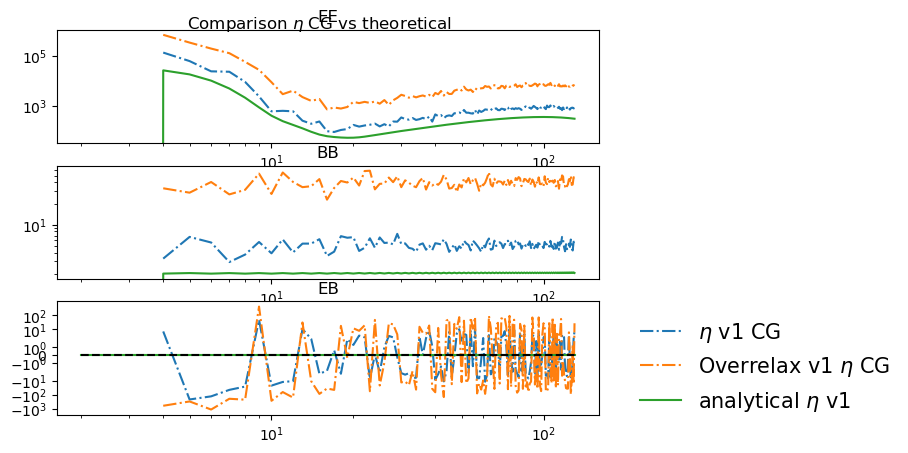

In [50]:
# list_correl = ['TT', 'EE', 'BB', 'TE', 'EB', 'TB']
list_correl = ['EE', 'BB', 'EB']

ell_arange = np.arange(c_ell_approx.shape[1]) + lmin

plt.figure(figsize=(7,5))
plt.suptitle(r"Comparison $\eta$ CG vs theoretical", y=0.91)

for j in range(number_correl_to_plot):
    ax = plt.subplot(311+j)
    plt.title(list_correl[j])

    # plt.plot(ell_arange, c_ell_approx.T[:,j], label='c_ell_approx')
    # plt.plot(ell_arange[lmin:], c_ells_eta[j,:]/fksy, '-.', label=r"$\eta$ CG")
    # plt.plot(ell_arange[lmin:], c_ells_eta_overrel[j,:]/fksy, '-.', label=r"Overrelax $\eta$ CG")
    plt.plot(ell_arange[lmin:], c_ells_eta_v1[j,:]/fksy, '-.', label=r"$\eta$ v1 CG")
    plt.plot(ell_arange[lmin:], c_ells_eta_overrel_v1[j,:]/fksy, '-.', label=r"Overrelax v1 $\eta$ CG")

    # plt.plot(ell_arange, analytical_eta_term[j,:], '-.', label=r"analytical $\eta$")
    # plt.plot(ell_arange, analytical_eta_term_2[j,:], label=r"analytical $\eta$ v2")
    plt.plot(ell_arange, analytical_eta_term_v1[j,:], label=r"analytical $\eta$ v1")
    # plt.plot(ell_arange[lmin:], 1/_cl_noise_harm, '-.', label=r"$N_c$")
    # plt.plot(ell_arange[lmin:], 1/theoretical_r0_total[j,:], label='C_approx')
    # if j < nstokes:
    #     plt.plot([ell_arange[0], ell_arange[-1]], [1,1], '--', color='black')
    # plt.plot([ell_arange[0], ell_arange[-1]], [0,0], '--', color='black')
    if nstokes == 3 and j < number_correl_to_plot-2:
        plt.xticks(color='w')

    if j <= nstokes-1:
        plt.loglog()
        # plt.ylim(ymin=noise_level/10.)
    else:
        plt.xscale('log')
        plt.yscale('symlog')
    # plt.legend()
    if j == position_legend:
        plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)
        plt.plot([ell_arange[0], ell_arange[-1]], [0,0], '--', color='black')


plt.show()

In [62]:
N_c_inv = jnp.copy(BtinvNB[0,0])
N_c_inv = N_c_inv.at[...,mask!=0].set(1/BtinvNB[0,0,mask!=0]/hp.nside2resol(nside)**2)

product_1 = np.einsum('cfp,ckp->fkp', BtinvN_sqrt, BtinvNB)#*N_c_inv

product_2 = np.einsum('ckp,kfp->cfp', BtinvNB, BtinvN_sqrt)

In [67]:
print(np.einsum('fkp,cfp->ckp', product_1, product_2)[:,:,100]/BtinvNB[0,0,100])
print(np.einsum('cfp,fkp->ckp', product_2, product_1)[:,:,100]/BtinvNB[0,0,100])


[[  1.          -4.72711814  -3.02899876]
 [ -4.72711814 132.70599784  10.36831334]
 [ -3.02899876  10.36831334  21.6719946 ]]
[[  1.          -4.72711814  -3.02899876]
 [ -4.72711814 132.70599784  10.36831334]
 [ -3.02899876  10.36831334  21.6719946 ]]


In [51]:
test_map_random_x = jax.random.normal(jax_key_PNRG, shape=(number_frequencies,nstokes,npix))

test_noise = np.einsum('kcp,cfp,fsp->ksp', BtinvNB, BtinvN_sqrt, test_map_random_x)[0]

test_noise_extended = np.vstack([np.zeros_like(test_noise[0]), test_noise])
cl_noise_test = hp.anafast(test_noise_extended, lmax=lmax, iter=n_iter)[indices_polar,lmin:]

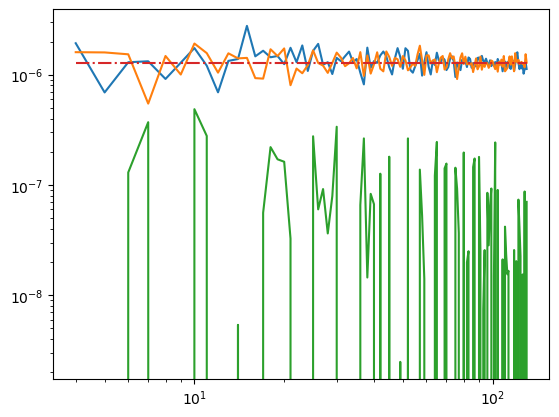

In [57]:
plt.plot(ell_arange[lmin:], cl_noise_test.T)
plt.plot(ell_arange[lmin:], _cl_noise_harm, '-.', label=r"$N_c$")
plt.loglog()
plt.show()

In [58]:
test_map_random_y = jax.random.normal(jax_key_PNRG, shape=(number_frequencies,nstokes,npix))

N_c_inv = jnp.copy(BtinvNB[0,0])
N_c_inv = N_c_inv.at[...,mask!=0].set(1/BtinvNB[0,0,mask!=0]/hp.nside2resol(nside)**2)

test_noise_2 = np.einsum('kcp,cfp,fsp->ksp', BtinvNB, BtinvN_sqrt, test_map_random_y)[0]*N_c_inv

test_noise_2_extended = np.vstack([np.zeros_like(test_noise_2[0]), test_noise_2])
cl_noise_test_2 = hp.anafast(test_noise_2_extended, lmax=lmax, iter=n_iter)[indices_polar,lmin:]

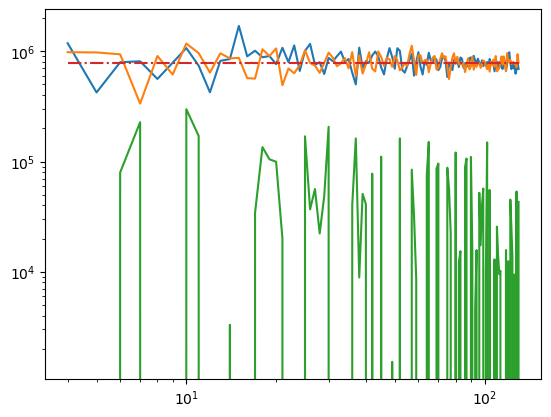

In [60]:
plt.plot(ell_arange[lmin:], cl_noise_test_2.T)
plt.plot(ell_arange[lmin:], 1/_cl_noise_harm, '-.', label=r"$1/N_c$")
plt.loglog()
plt.show()

In [61]:
N_c_inv = jnp.copy(BtinvNB[0,0])
N_c_inv = N_c_inv.at[...,mask!=0].set(1/BtinvNB[0,0,mask!=0]/hp.nside2resol(nside)**2)

test_noise_3 = np.einsum('kcp,cfp,fsp->ksp', BtinvNB, BtinvN_sqrt, test_noise)[0]*N_c_inv

test_noise_3_extended = np.vstack([np.zeros_like(test_noise_3[0]), test_noise_2])
cl_noise_test_3 = hp.anafast(test_noise_3_extended, lmax=lmax, iter=n_iter)[indices_polar,lmin:]

ValueError: einstein sum subscripts string contains too many subscripts for operand 2

In [ ]:
plt.plot(ell_arange[lmin:], cl_noise_test_3.T)
plt.plot(ell_arange[lmin:], np.ones_like(ell_arange[lmin:]), '-.', label=r"$1/N_c$")
plt.loglog()
plt.show()